# mmpretrain基本使用

## 安装

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.0.1+cu118
False


In [2]:
!git clone https://github.com/open-mmlab/mmpretrain.git

fatal: destination path 'mmpretrain' already exists and is not an empty directory.


In [3]:
import os
os.chdir("/content/mmpretrain")
print(f"current executing dir:{os.getcwd()}")

current executing dir:/content/mmpretrain


In [4]:
!pip install openmim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!mim --help

Usage: mim [OPTIONS] COMMAND [ARGS]...

  OpenMMLab Command Line Interface.

  MIM provides a unified API for launching and
  installing OpenMMLab projects and their
  extensions, and managing the OpenMMLab model
  zoo.

Options:
  --user-conf FILE  Read option defaults from the
                    .mimrc file  [default:
                    /root/.mimrc]
  --version         Show the version and exit.
  -h, --help        Show this message and exit.

Commands:
  download    Download checkpoints from url...
  gridsearch  Perform Hyper-parameter search.
  install     Install packages.
  list        List packages.
  run         Run arbitrary command of a...
  search      Show the information of packages.
  test        Perform Testing.
  train       Perform Training.
  uninstall   Uninstall package.


In [6]:
!mim install -e ".[multimodal]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
Obtaining file:///content/mmpretrain
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmpretrain
    Found existing installation: mmpretrain 1.0.0rc8
    Uninstalling mmpretrain-1.0.0rc8:
      Successfully uninstalled mmpretrain-1.0.0rc8
  Running setup.py develop for mmpretrain


In [7]:
import mmpretrain
mmpretrain.__version__

'1.0.0rc8'

## 基本语法

In [ ]:
from mmpretrain import get_model,list_models,inference_model

In [ ]:
# 列举图像分类相关的resnet18的模型
list_models(task="Image Classification",pattern="resnet18")

['resnet18_8xb16_cifar10', 'resnet18_8xb32_in1k']

In [ ]:
# 列举图像描述任务相关的模型
list_models(task= "Image Caption",pattern="blip")

['blip-base_3rdparty_caption', 'blip2-opt2.7b_3rdparty-zeroshot_caption']

In [ ]:
model = get_model('resnet18_8xb16_cifar10')

In [ ]:
type(model),type(model.backbone)

(mmpretrain.models.classifiers.image.ImageClassifier,
 mmpretrain.models.backbones.resnet_cifar.ResNet_CIFAR)

In [ ]:
model2 = get_model('resnet18_8xb32_in1k')
type(model2),type(model2.backbone)

(mmpretrain.models.classifiers.image.ImageClassifier,
 mmpretrain.models.backbones.resnet.ResNet)

## 文件关联

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
os.getcwd()
os.chdir("/content")

In [10]:
os.getcwd()

'/content'

## 推理演示

**注意**
+ 这里的模型没有权重，只是有网络结构，
+ 所以直接进行推理的话，权重只有一些随机的初始值，推理结果就是混乱的

In [ ]:
inference_model(model,"/content/drive/MyDrive/OpenMMLab/Exercise_2/litchi_test.jpeg",show=True)

Output()

06/07 14:24:11 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


{'pred_scores': array([0.10890521, 0.10796862, 0.09426554, 0.094574  , 0.0955568 ,
        0.0969913 , 0.09384347, 0.09945609, 0.10838135, 0.1000575 ],
       dtype=float32),
 'pred_label': 0,
 'pred_score': 0.10890521109104156,
 'pred_class': 'airplane'}

**载入模型权重**
+ 调用时直接把对应的模型的名字放进去，就会去下载了
+ 给了张荔枝的图片，出来的语言描述是：`{'pred_caption': 'a close up of a fruit on a white background'}`。感觉还行

In [ ]:
inference_model("blip-base_3rdparty_caption","/content/drive/MyDrive/OpenMMLab/Exercise_2/litchi_test.jpeg",show=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'BlipTokenizer'.


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmclassification/v1/blip/blip-base_3rdparty_coco-caption_20230419-a5b71af3.pth


Downloading: "https://download.openmmlab.com/mmclassification/v1/blip/blip-base_3rdparty_coco-caption_20230419-a5b71af3.pth" to /root/.cache/torch/hub/checkpoints/blip-base_3rdparty_coco-caption_20230419-a5b71af3.pth


KeyboardInterrupt: ignored

# 用mmpretrain基于Resnet18进行分类任务的微调训练

## 1. 数据和config简单认识

这里第一步就是要自己处理数据集，处理成合适的格式

以猫狗数据集为例，如下：
```bash
cats_dogs_dataset  tree ./ --filelimit=10
./
├── test_set
│   ├── cats  [1012 entries exceeds filelimit, not opening dir]
│   └── dogs  [1013 entries exceeds filelimit, not opening dir]
├── training_set
│   ├── cats  [3201 entries exceeds filelimit, not opening dir]
│   └── dogs  [3205 entries exceeds filelimit, not opening dir]
└── val_set
    ├── cats  [800 entries exceeds filelimit, not opening dir]
    └── dogs  [801 entries exceeds filelimit, not opening dir]

9 directories, 0 files

```
只要按照对应目录放好就行，不需要有什么coco.json那样的标记文件

In [ ]:
!cd /content/mmpretrain && ls  configs

arcface       csra	       hrnet	     ofa	    simclr
barlowtwins   davit	       inception_v3  poolformer     simmim
_base_	      deit	       lenet	     regnet	    simsiam
beit	      deit3	       levit	     replknet	    swav
beitv2	      densecl	       mae	     repmlp	    swin_transformer
blip	      densenet	       maskfeat      repvgg	    swin_transformer_v2
blip2	      dinov2	       milan	     res2net	    t2t_vit
byol	      edgenext	       mixmim	     resnest	    tinyvit
cae	      efficientformer  mlp_mixer     resnet	    tnt
chinese_clip  efficientnet     mobilenet_v2  resnext	    twins
clip	      efficientnet_v2  mobilenet_v3  revvit	    van
conformer     eva	       mobileone     riformer	    vgg
convmixer     eva02	       mobilevit     sam	    vig
convnext      flamingo	       mocov2	     seresnet	    vision_transformer
convnext_v2   glip	       mocov3	     shufflenet_v1  wrn
cspnet	      hornet	       mvit	     shufflenet_v2  xcit


In [ ]:
from mmengine import Config

In [ ]:
cfg = Config.fromfile('/content/mmpretrain/configs/resnet/resnet18_8xb32_in1k.py')
cfg.model

{'type': 'ImageClassifier',
 'backbone': {'type': 'ResNet',
  'depth': 18,
  'num_stages': 4,
  'out_indices': (3,),
  'style': 'pytorch'},
 'neck': {'type': 'GlobalAveragePooling'},
 'head': {'type': 'LinearClsHead',
  'num_classes': 1000,
  'in_channels': 512,
  'loss': {'type': 'CrossEntropyLoss', 'loss_weight': 1.0},
  'topk': (1, 5)}}

In [ ]:
cfg.model.head.num_classes=2
cfg.model

{'type': 'ImageClassifier',
 'backbone': {'type': 'ResNet',
  'depth': 18,
  'num_stages': 4,
  'out_indices': (3,),
  'style': 'pytorch'},
 'neck': {'type': 'GlobalAveragePooling'},
 'head': {'type': 'LinearClsHead',
  'num_classes': 2,
  'in_channels': 512,
  'loss': {'type': 'CrossEntropyLoss', 'loss_weight': 1.0},
  'topk': (1, 5)}}

In [ ]:
cfg.train_dataloader

{'batch_size': 32,
 'num_workers': 5,
 'dataset': {'type': 'ImageNet',
  'data_root': 'data/imagenet',
  'ann_file': 'meta/train.txt',
  'data_prefix': 'train',
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'type': 'RandomResizedCrop', 'scale': 224},
   {'type': 'RandomFlip', 'prob': 0.5, 'direction': 'horizontal'},
   {'type': 'PackInputs'}]},
 'sampler': {'type': 'DefaultSampler', 'shuffle': True}}

In [ ]:
cfg.dataset_type

'ImageNet'

In [ ]:
cfg.dataset_type = "Dummy"
cfg.dataset_type

'Dummy'

可以看到，对`dataset_type`进行修改并不会影响`train_dataloader`中的参数

```python
dataset_type = 'ImageNet'
train_dataloader = dict(
    batch_size=32,
    num_workers=5,
    dataset=dict(
        type=dataset_type, # 这里直接用了上面定义的
        data_root='data/imagenet',
        ann_file='meta/train.txt',
        data_prefix='train',
        pipeline=train_pipeline),
    sampler=dict(type='DefaultSampler', shuffle=True),
)

```



+ 因为一旦配置文件加载完成，中间变量的连接关系就没有了，所以无法对train_dataloader中的参数造成影响
+ 代码实际读入的就是`train_dataloader`中的内容，一旦读取解析完毕，那个`dataset_type`和已经读入到配置中的type就没有连接关系了

In [ ]:
cfg.train_dataloader

{'batch_size': 32,
 'num_workers': 5,
 'dataset': {'type': 'ImageNet',
  'data_root': 'data/imagenet',
  'ann_file': 'meta/train.txt',
  'data_prefix': 'train',
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'type': 'RandomResizedCrop', 'scale': 224},
   {'type': 'RandomFlip', 'prob': 0.5, 'direction': 'horizontal'},
   {'type': 'PackInputs'}]},
 'sampler': {'type': 'DefaultSampler', 'shuffle': True}}

所以一般还是用文本编辑器来改好config，然后直接运行

## 基于修改过的config进行finetune

这里先用猫狗数据集作为实验，看看效果

In [ ]:
!tar -xvf /content/drive/MyDrive/cats_dogs_dataset.tar  -C /content/

注意，
+ 这里`--work-dir XXXX`不用加等号，不是`--work-dir=/content/data/...`
+ 另外，还是要`workdir/resnet18_finetune_catsdogs`指定一个目录，不然就直接放在`workdir`里了。

In [ ]:
!mim train mmpretrain /content/drive/MyDrive/OpenMMLab/Exercise_2/resnet18_finetune_catsdogs.py --work-dir /content/drive/MyDrive/OpenMMLab/workdir/resnet18_finetune_catsdogs

In [ ]:
 !mim test mmpretrain /content/drive/MyDrive/OpenMMLab/Exercise_2/resnet18_finetune_catsdogs.py \
 --checkpoint /content/drive/MyDrive/OpenMMLab/workdir/resnet18_finetune_catsdogs/best_accuracy_top1_epoch_5.pth\
 --out /content/drive/MyDrive/OpenMMLab/workdir/resnet18_finetune_catsdogs/result.pkl

In [ ]:
!mim run mmpretrain analyze_results /content/drive/MyDrive/OpenMMLab/Exercise_2/resnet18_finetune_catsdogs.py\
/content/drive/MyDrive/OpenMMLab/workdir/resnet18_finetune_catsdogs/result.pkl\
--out-dir /content/drive/MyDrive/OpenMMLab/Exercise_2/outputs

In [ ]:
!mim run mmpretrain confusion_matrix /content/drive/MyDrive/OpenMMLab/Exercise_2/resnet18_finetune_catsdogs.py\
/content/drive/MyDrive/OpenMMLab/workdir/resnet18_finetune_catsdogs/result.pkl\
--show --include-values

## 推理

In [ ]:
from mmpretrain import ImageClassificationInferencer

In [ ]:
inferencer = ImageClassificationInferencer('/content/drive/MyDrive/OpenMMLab/Exercise_2/resnet18_finetune_catsdogs.py',
                                           pretrained='/content/drive/MyDrive/OpenMMLab/workdir/resnet18_finetune_catsdogs/best_accuracy_top1_epoch_5.pth')

Loads checkpoint by local backend from path: /content/drive/MyDrive/OpenMMLab/workdir/resnet18_finetune_catsdogs/best_accuracy_top1_epoch_5.pth


In [ ]:
inferencer("/content/drive/MyDrive/OpenMMLab/Exercise_2/3321686149643_.pic.jpg",show=True)

[{'pred_scores': array([0.9982535 , 0.00174642], dtype=float32),
  'pred_label': 0,
  'pred_score': 0.9982535243034363,
  'pred_class': 'cats'}]

# 用mmpretrain基于Resnet50进行水果30类分类微调

## 数据准备

解压数据集

In [ ]:
!mkdir /content/fruit30_train
!tar -xvf /content/drive/MyDrive/fruit30_train.tar  -C /content/fruit30_train

把meta标注文件链接到解压后的数据集中

In [ ]:
!ln -s /content/drive/'My Drive'/OpenMMLab/Exercise_2/fruit30_meta  /content/fruit30_train

## 训练

开始训练（提前想好workdir）

In [ ]:
!mim train mmpretrain /content/drive/MyDrive/OpenMMLab/Exercise_2/resnet50_finetune_fruits.py \
--work-dir /content/drive/MyDrive/OpenMMLab/workdir/resnet50_finetune_fruits

Training command is /usr/bin/python3 /content/mmpretrain/mmpretrain/.mim/tools/train.py /content/drive/MyDrive/OpenMMLab/Exercise_2/resnet50_finetune_fruits.py --launcher none --work-dir /content/drive/MyDrive/OpenMMLab/workdir/resnet50_finetune_fruits. 
06/08 03:27:52 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 98891304
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080

开始测试

In [ ]:
!mim test mmpretrain /content/drive/MyDrive/OpenMMLab/Exercise_2/resnet50_finetune_fruits.py \
 --checkpoint /content/drive/MyDrive/OpenMMLab/workdir/resnet50_finetune_fruits/best_accuracy_top1_epoch_9.pth\
 --out /content/drive/MyDrive/OpenMMLab/workdir/resnet50_finetune_fruits/result.pkl

Testing command is /usr/bin/python3 /content/mmpretrain/mmpretrain/.mim/tools/test.py /content/drive/MyDrive/OpenMMLab/Exercise_2/resnet50_finetune_fruits.py /content/drive/MyDrive/OpenMMLab/workdir/resnet50_finetune_fruits/best_accuracy_top1_epoch_9.pth --launcher none --out /content/drive/MyDrive/OpenMMLab/workdir/resnet50_finetune_fruits/result.pkl. 
06/08 03:36:22 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1542793980
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 

分析结果（分类成功和失败的图像）

In [ ]:
!mim run mmpretrain analyze_results /content/drive/MyDrive/OpenMMLab/Exercise_2/resnet50_finetune_fruits.py\
/content/drive/MyDrive/OpenMMLab/workdir/resnet50_finetune_fruits/result.pkl\
--out-dir /content/drive/MyDrive/OpenMMLab/Exercise_2/outputs/fruit30

Use the script /content/mmpretrain/mmpretrain/.mim/tools/analysis_tools/analyze_results.py for command analyze_results.
The command to call is /usr/bin/python3 /content/mmpretrain/mmpretrain/.mim/tools/analysis_tools/analyze_results.py /content/drive/MyDrive/OpenMMLab/Exercise_2/resnet50_finetune_fruits.py /content/drive/MyDrive/OpenMMLab/workdir/resnet50_finetune_fruits/result.pkl --out-dir /content/drive/MyDrive/OpenMMLab/Exercise_2/outputs/fruit30. 
06/08 03:38:14 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
/usr/local/lib/python3.10/dist-packages/mmengine/visualization/utils.py:240: UserWarning: Glyph 33426 (\N{CJK UNIFIED IDEOGRAPH-8292}) missing from current font.
  s, (width, height) = canvas.print_to_buffer()
/usr/local/lib/python3.10/dist-packages/mmengine/visualization/utils.py:240: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from current font.
  s, (width, height) = canvas.print_to_buffer()
/usr/local/lib/pyth

混淆矩阵分析

In [ ]:
!mim run mmpretrain confusion_matrix /content/drive/MyDrive/OpenMMLab/Exercise_2/resnet50_finetune_fruits.py\
/content/drive/MyDrive/OpenMMLab/workdir/resnet50_finetune_fruits/result.pkl\
--show --include-values

Use the script /content/mmpretrain/mmpretrain/.mim/tools/analysis_tools/confusion_matrix.py for command confusion_matrix.
The command to call is /usr/bin/python3 /content/mmpretrain/mmpretrain/.mim/tools/analysis_tools/confusion_matrix.py /content/drive/MyDrive/OpenMMLab/Exercise_2/resnet50_finetune_fruits.py /content/drive/MyDrive/OpenMMLab/workdir/resnet50_finetune_fruits/result.pkl --show --include-values. 
Figure(1000x1000)
The script finished successfully.


## 推理

In [13]:
from mmpretrain import ImageClassificationInferencer

inferencer = ImageClassificationInferencer('/content/drive/MyDrive/OpenMMLab/Exercise_2/resnet50_finetune_fruits.py',
                                           pretrained='/content/drive/MyDrive/OpenMMLab/workdir/resnet50_finetune_fruits/best_accuracy_top1_epoch_9.pth')

Loads checkpoint by local backend from path: /content/drive/MyDrive/OpenMMLab/workdir/resnet50_finetune_fruits/best_accuracy_top1_epoch_9.pth


In [24]:
# visual_img = inferencer("/content/drive/MyDrive/OpenMMLab/Exercise_2/litchi_test.jpeg",show=True)

visual_img = inferencer("/content/drive/MyDrive/OpenMMLab/Exercise_2/litchi_test.jpeg",show_dir="/content/drive/MyDrive/OpenMMLab/Exercise_2/")

In [25]:
visual_img[0]

{'pred_scores': array([9.8617036e-08, 4.6559649e-09, 4.7238853e-09, 6.1176209e-08,
        1.1758071e-06, 1.9768613e-05, 6.5803279e-06, 2.8776577e-09,
        1.9613218e-09, 4.2568220e-09, 5.1932891e-10, 1.3199590e-07,
        1.7486315e-07, 2.1758628e-05, 4.7297416e-07, 3.6769190e-08,
        1.7304191e-06, 6.3718785e-06, 4.1835184e-09, 9.9994004e-01,
        5.3369670e-10, 1.9838148e-11, 1.4331825e-06, 1.3142658e-08,
        1.2287903e-09, 1.3498119e-07, 3.3858927e-10, 1.2507003e-09,
        4.5590962e-09, 2.9508143e-09], dtype=float32),
 'pred_label': 19,
 'pred_score': 0.999940037727356,
 'pred_class': '荔枝'}

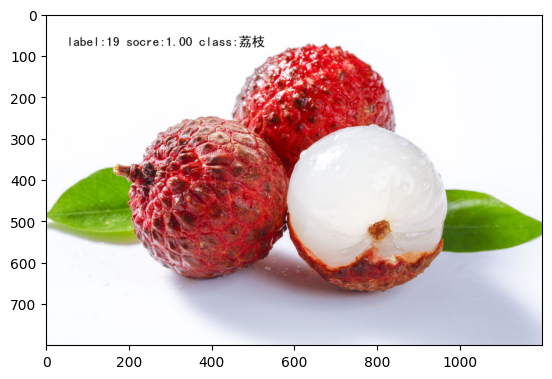

In [31]:
from PIL import ImageFont, ImageDraw, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img_path = "/content/drive/MyDrive/OpenMMLab/Exercise_2/litchi_test.jpeg"
fontpath = "/content/drive/MyDrive/OpenMMLab/SimHei.ttf" # <== 这里是宋体路径 
font = ImageFont.truetype(fontpath, 32)

img2=cv2.imread(img_path)
img = Image.fromarray(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

draw = ImageDraw.Draw(img)
pred_class = visual_img[0]['pred_class']
pred_label=visual_img[0]['pred_label']
pred_score=visual_img[0]['pred_score']
draw.text((50,50 ), 'label:{} socre:{:.2f} class:{}'.format(pred_label,pred_score,pred_class), (0,0,0), font=font)

img = np.asarray(img)
plt.imshow(img)

In [ ]:
import mmengine
mmengine.__version__

'0.7.4'